# Prioror tests and data preparation

Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import truncnorm, beta, norm, uniform
import matplotlib.pyplot as plt
import os
import mne

## Plots of priors' distributions

### Ter (non-decision time)

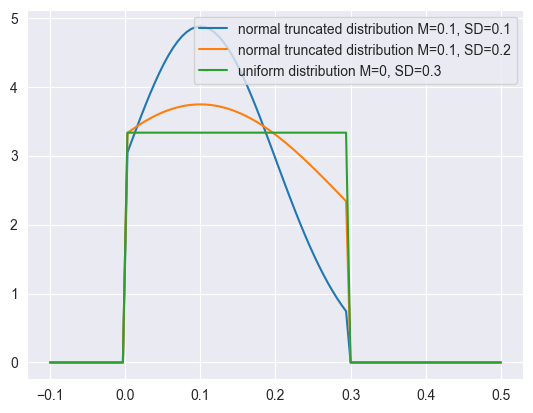

In [2]:
lower_boundary = 0
upper_boundary = 0.3
ter_mean = 0.1
ter_std = 0.1

x_range = np.linspace(-0.1, 0.5, 100)
a, b = (lower_boundary - ter_mean) / ter_std, (upper_boundary - ter_mean) / ter_std
ter = truncnorm.pdf(x_range, a, b, loc=ter_mean, scale=ter_std)
plt.plot(x_range,ter, label = f'normal truncated distribution M={ter_mean}, SD={ter_std}')

ter_mean = 0.1
ter_std = 0.2

x_range = np.linspace(-0.1, 0.5, 100)
a, b = (lower_boundary - ter_mean) / ter_std, (upper_boundary - ter_mean) / ter_std
ter = truncnorm.pdf(x_range, a, b, loc=ter_mean, scale=ter_std)
plt.plot(x_range,ter, label = f'normal truncated distribution M={ter_mean}, SD={ter_std}')

ter_mean = 0
ter_std = 0.3
ter = uniform.pdf(x_range, loc=ter_mean, scale=ter_std)
plt.plot(x_range,ter, label = f'uniform distribution M={ter_mean}, SD={ter_std}')

plt.legend()

### Alpha (threshold)

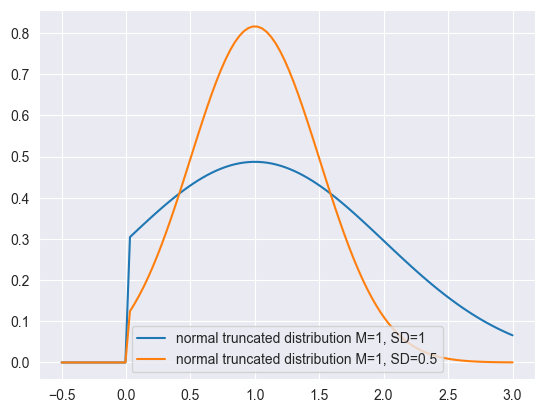

In [3]:
lower_boundary = 0
upper_boundary = 3
alpha_mean = 1
alpha_std = 1

x_range = np.linspace(-0.5, 3, 100)
a, b = (lower_boundary - alpha_mean) / alpha_std, (upper_boundary - alpha_mean) / alpha_std
alpha = truncnorm.pdf(x_range, a, b, loc=alpha_mean, scale=alpha_std)
plt.plot(x_range,alpha, label = f'normal truncated distribution M={alpha_mean}, SD={alpha_std}')

alpha_mean = 1
alpha_std = 0.5

x_range = np.linspace(-0.5, 3, 100)
a, b = (lower_boundary - alpha_mean) / alpha_std, (upper_boundary - alpha_mean) / alpha_std
alpha = truncnorm.pdf(x_range, a, b, loc=alpha_mean, scale=alpha_std)
plt.plot(x_range,alpha, label = f'normal truncated distribution M={alpha_mean}, SD={alpha_std}')

plt.legend()

### Beta (bias)

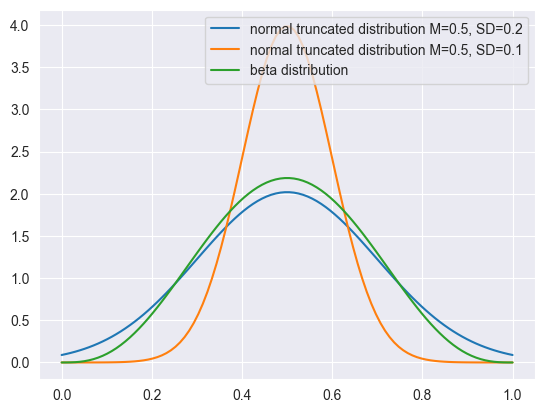

In [4]:
lower_boundary = 0
upper_boundary = 1
beta_mean = 0.5
beta_std = 0.2

x_range = np.linspace(0, 1, 100)
a, b = (lower_boundary - beta_mean) / beta_std, (upper_boundary - beta_mean) / beta_std
beta_ = truncnorm.pdf(x_range, a, b, loc=beta_mean, scale=beta_std)
plt.plot(x_range,beta_, label=f'normal truncated distribution M={beta_mean}, SD={beta_std}')

beta_mean = 0.5
beta_std = 0.1

x_range = np.linspace(0, 1, 100)
a, b = (lower_boundary - beta_mean) / beta_std, (upper_boundary - beta_mean) / beta_std
beta_ = truncnorm.pdf(x_range, a, b, loc=beta_mean, scale=beta_std)
plt.plot(x_range,beta_, label=f'normal truncated distribution M={beta_mean}, SD={beta_std}')

beta_beta = beta.pdf(x_range, a=4, b=4)
plt.plot(x_range,beta_beta, label='beta distribution')

plt.legend()

### Delta (drift rate)

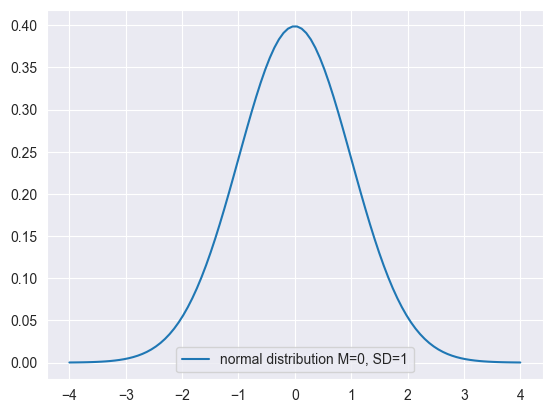

In [5]:
delta_mean = 0
delta_std = 1

x_range = np.linspace(-4, 4, 100)
delta = norm.pdf(x_range, loc=delta_mean, scale=delta_std)
plt.plot(x_range, delta, label=f'normal distribution M={delta_mean}, SD={delta_std}')

plt.legend()

## Read and prepare data

In [2]:
paradigm = 'FLA'
case = 'RE'

data_path = f'data/beh_eeg_{paradigm}/{paradigm}/preprocessed/wavelets_th-045/'
data_df = pd.DataFrame()

id_list = [item.split('.')[0] for item in os.listdir(data_path)][:20]

for participant_id in id_list:
    participant_data_df = pd.read_pickle(f'{data_path}{participant_id}.pkl')
    participant_data_df['ID'] = participant_id.split("_")[1]
    data_df = pd.concat([data_df, participant_data_df], ignore_index=True)

Featurize ERN: peak amplitude at FCz
- EEG column in bad trials will be filled with NaN

In [21]:
channel = 'FCz'

data_df['ERN'] = data_df.apply(
    lambda row: np.min(row['epoch'].get_data(picks=channel, tmin=0.0, tmax=0.1).flatten()) if channel not in row['drop_log'] else np.nan, 
    axis=1
)


In [22]:
# drop column with epochs to better display df
columns_to_drop = ['epoch']
data_df = data_df.drop(columns=columns_to_drop)

Mark bad participants (less than 6 trials)

In [29]:
cleared_data_df = data_df.copy(deep=True)

ids = np.unique(data_df['ID'])
n = 6

for participant_id in ids:
    participant_data = data_df[data_df['ID'] == participant_id]['ERN'].to_numpy()
    good_trials = np.count_nonzero(~np.isnan(participant_data.flatten()))
    
    if good_trials < n:
        print(f"Participant {participant_id} nas {good_trials} good trial. Rejecting")
        cleared_data_df = cleared_data_df[cleared_data_df['ID'] != participant_id]

cleared_ids = np.unique(cleared_data_df['ID'])

Participant FLA-222 nas 0 good trial. Rejecting


Rename columns

In [30]:
columns_name_mapping = {'trial number': 'trial_number'}
cleared_data_df = cleared_data_df.rename(columns=columns_name_mapping)

cleared_data_df

,block_type,trial_type,cue_name,target_name,response,rt,reaction,threshold_rt,empty_screen_between_trials,cue_show_time,...,flanker_show_time,target_show_time,empty_screen_after_response_show_time,feedback_show_time,feedback_type,trial_number,event,drop_log,ID,ERN
0,experiment,congruent,NaN,congruent_lll,l,0.268716,correct,0.420000,0.662629,NaN,...,0.08,0.6,1.0,0.8,feedback_good,1,2,(),FLA-169,-1.392086e-05
1,experiment,congruent,NaN,congruent_lll,l,0.309487,correct,0.344358,0.752320,NaN,...,0.08,0.6,1.0,0.8,feedback_good,2,2,(),FLA-169,-2.783326e-06
2,experiment,incongruent,NaN,incongruent_rlr,l,0.397239,correct,0.309487,0.629174,NaN,...,0.08,0.6,1.0,0.8,feedback_bad,3,0,(),FLA-169,-3.684688e-06
3,experiment,congruent,NaN,congruent_rrr,r,0.309485,correct,0.353363,0.753142,NaN,...,0.08,0.6,1.0,0.8,feedback_good,4,2,(),FLA-169,7.475740e-07
4,experiment,incongruent,NaN,incongruent_lrl,r,0.386673,correct,0.309487,0.660532,NaN,...,0.08,0.6,1.0,0.8,feedback_bad,5,0,(),FLA-169,-5.791032e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5987,experiment,incongruent,NaN,incongruent_rlr,r,0.184141,incorrect,0.198944,0.675121,NaN,...,0.08,0.6,1.0,0.8,NaN,296,1,(),FLA-156,-1.201548e-05
5988,experiment,congruent,NaN,congruent_rrr,r,0.160584,correct,0.198944,0.725439,NaN,...,0.08,0.6,1.0,0.8,feedback_good,297,2,(),FLA-156,-3.168268e-06
5989,experiment,congruent,NaN,congruent_lll,l,0.222714,correct,0.197181,0.736859,NaN,...,0.08,0.6,1.0,0.8,feedback_bad,298,2,(),FLA-156,-1.172474e-05
5990,experiment,congruent,NaN,congruent_lll,l,0.153627,correct,0.198944,0.605223,NaN,...,0.08,0.6,1.0,0.8,feedback_good,299,2,(),FLA-156,-9.432138e-06


In [32]:
test_df = pd.DataFrame()

# create mapping IDs to ordinal 1-N number
id_mapping = {old_id: new_id for new_id, old_id in enumerate(cleared_data_df['ID'].unique(), start=1)}

# create dataframe in a form stan expects
for idx, row in cleared_data_df.iterrows():
    acc = 1 if row['reaction'] == 'correct' else -1
    condition = 1 if row['trial_type'] == 'congruent' else -1
    condition_index = 1 if row['trial_type'] == 'congruent' else 2

    row_data = pd.DataFrame({
        'trial_number': [row['trial_number']],
        'ID': int(row['ID'].split("-")[-1]),
        'participant_index': [id_mapping[row['ID']]],
        'condition': condition,
        'condition_index': condition_index,
        'rt': row['rt'],
        'acc': acc,
        'ern': row['ERN'],
        'y':  row['rt'] * acc
    })

    test_df = pd.concat([test_df, row_data], ignore_index=True)

test_df

,trial_number,ID,participant_index,condition,condition_index,rt,acc,ern,y
0,1,169,1,1,1,0.268716,1,-1.392086e-05,0.268716
1,2,169,1,1,1,0.309487,1,-2.783326e-06,0.309487
2,3,169,1,-1,2,0.397239,1,-3.684688e-06,0.397239
3,4,169,1,1,1,0.309485,1,7.475740e-07,0.309485
4,5,169,1,-1,2,0.386673,1,-5.791032e-06,0.386673
...,...,...,...,...,...,...,...,...,...
5688,296,156,19,-1,2,0.184141,-1,-1.201548e-05,-0.184141
5689,297,156,19,1,1,0.160584,1,-3.168268e-06,0.160584
5690,298,156,19,1,1,0.222714,1,-1.172474e-05,0.222714
5691,299,156,19,1,1,0.153627,1,-9.432138e-06,0.153627


In [34]:
test_df.to_csv('data/twenty_participants_eeg_test_set.csv')